# Demo: beat finding paradigm

**Authors:   Manuel Anglada-Tort, Peter Harrison, Nori Jacoby**

This demo shows how to apply _REPP_ in beat finding paradigms using finger tapping experiments. 


In [2]:
# Before starting, set the right working dir and imports
import os
if 'path_to_dir' not in globals():
    path_to_dir = os.path.split(os.getcwd())[0]
os.chdir(path_to_dir)

# working directories for input and output files
input_dir = "music"
output_dir = "notebook/output"

import matplotlib
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
# For Jupyter notebooks, use inline backend (no need to set GUI backend)
%matplotlib inline

# Finally, import REPP configuration for SMS experiments
# Load experiment parameters from config file
from repp.config import sms_tapping


# Define filenames for outputs
filenames = {
    'stim_info_file': 'stim_info.json',
    'audio_filename': 'stim_audio.wav',
    'recording_filename': 'recording.wav',
    'plot_filename': 'beat_finding_plot.png',
    'title_plot': 'Beat Finding Analysis'
}




## 1 Stimulus preparation
We can now start with the first step: preparing the audio stimulus to be used with _REPP_

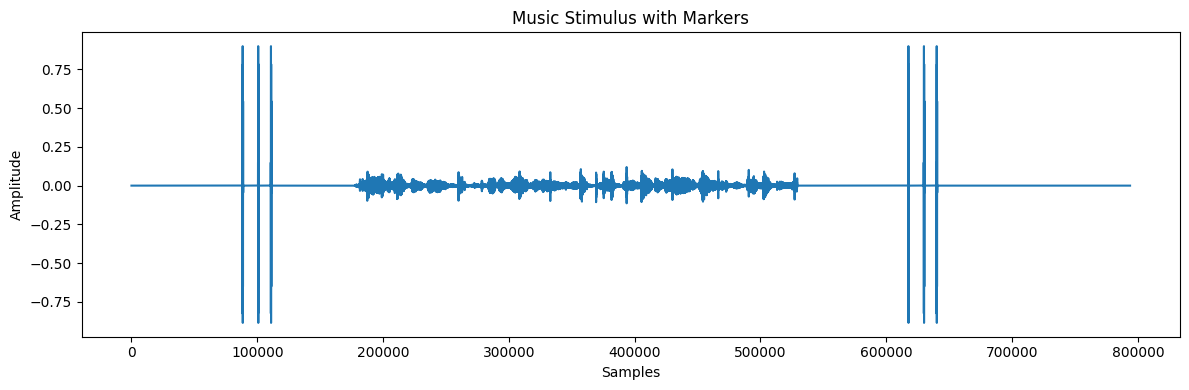

In [4]:
from repp.stimulus import REPPStimulus
import json
import numpy as np

stimulus = REPPStimulus("temp", config=sms_tapping)

# Define helper functions for creating music stimulus (avoid importing experiment.py which has PsyNet dependencies)
def load_audio_only_from_file(stimulus, fs, audio_filename):
    """Load audio file without requiring onsets file."""
    return stimulus.load_resample_file(fs, audio_filename)

def filter_and_add_markers_no_onsets(stim, config):
    """Apply filtering and add markers without requiring onset information."""
    stimulus = REPPStimulus("temp", config=config)
    
    # Apply spectral filtering
    filtered_stim = stimulus.filter_stim(
        config.FS, stim, config.STIM_RANGE, config.STIM_AMPLITUDE
    )
    
    # Create marker sounds
    markers_sound = stimulus.make_markers_sound(
        config.FS,
        config.MARKERS_DURATION,
        config.MARKERS_ATTACK,
        config.MARKERS_RANGE,
        config.MARKERS_AMPLITUDE
    )
    
    # Add markers at beginning and end
    markers_onsets, markers_channel = stimulus.add_markers_sound(
        config.FS,
        stim,
        config.MARKERS_IOI,
        config.MARKERS_BEGINNING,
        config.MARKERS_END,
        config.STIM_BEGINNING,
        config.MARKERS_END_SLACK
    )
    
    # Combine markers with filtered stimulus
    stim_prepared = stimulus.put_clicks_in_audio(markers_channel, config.FS, markers_sound, markers_onsets)
    stim_start_samples = int(round(config.STIM_BEGINNING * config.FS / 1000.0))
    stim_prepared[stim_start_samples:(stim_start_samples + len(filtered_stim))] += filtered_stim
    
    stim_duration = len(stim_prepared) / config.FS
    
    # Create minimal stim_info for beat-finding task
    stim_info = {
        'stim_duration': stim_duration,
        'stim_onsets': [],  # Empty for beat-finding
        'stim_shifted_onsets': [],  # Empty for beat-finding
        'onset_is_played': np.array([]),  # Empty for beat-finding
        'markers_onsets': markers_onsets,
        'stim_name': 'beat_finding_music'
    }
    
    return stim_prepared, stim_info

def create_music_stim_with_repp_beat_finding(stim_name, audio_filename, fs=44100):
    """Create music stimulus for beat-finding task without requiring onsets file."""
    stimulus = REPPStimulus("temp", config=sms_tapping)
    
    # Load audio file
    stim = load_audio_only_from_file(stimulus, fs, audio_filename)
    
    # Convert stereo to mono if needed
    if len(stim.shape) == 2:
        stim = stim[:, 0]
    
    # Apply filtering and add markers
    stim_prepared, stim_info = filter_and_add_markers_no_onsets(stim, sms_tapping)
    stim_info["stim_name"] = stim_name
    
    # NumpySerializer equivalent - convert numpy arrays to lists for JSON
    info = json.dumps(stim_info, default=lambda obj: obj.tolist() if hasattr(obj, 'tolist') else obj)
    return stim_prepared, info

# Create the stimulus for music beat finding
stim_prepared, stim_info_json = create_music_stim_with_repp_beat_finding("stim_music1", "music/0R8IbpKXavM.wav")
stim_info = json.loads(stim_info_json)


# Plot
plt.figure(figsize=(12, 4))
plt.plot(stim_prepared)
plt.title('Music Stimulus with Markers')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# save stimulus info
REPPStimulus.to_json(
    stim_info,
    os.path.join(output_dir,filenames['stim_info_file'])
)

# save audio stimulus
REPPStimulus.to_wav(
    stim_prepared,
    os.path.join(output_dir,filenames['audio_filename']),
    sms_tapping.FS
)

## 2 Recording phase
**Instructions:**

    - Only use the laptop speakers (unplug headphones or wireless devices)
    - Turn on your volume
    - Tap on the surface of your laptop with your index finger (do not tap on any key or trackpad)

In [5]:
import sounddevice as sd

print("****RECORDING PHASE: Please tap in time to the music")

myrecording = sd.playrec(stim_prepared, stimulus.config.FS, channels=1)
sd.wait()  # Wait until recording is finished

# save recording to wav
REPPStimulus.to_wav(
    myrecording,
    os.path.join(output_dir,filenames['recording_filename']),
    stimulus.config.FS
)

****RECORDING PHASE: Please tap in time to the music


## 3 Analysis: signal processing and performance analysis

In [6]:
# Beat Finding Analysis

from repp_beatfinding.beat_detection import (
    do_beat_detection_analysis,
)

output, extracted_onsets, stats = do_beat_detection_analysis(
    os.path.join(output_dir, filenames['recording_filename']),
    filenames['title_plot'],
    os.path.join(output_dir, filenames['plot_filename']),
    stim_info=stim_info
)


Preparing marker onsets...
Extracting audio signals from mono recording...
reading audio file:
fs=44100 len(samples)=793800
Extracting raw onsets from audio signals...
Aligning onsets...
Tapping analysis...
Analysing results...
Creating plot: Beat Finding Analysis
Data extracted - Time points: 396000, Taps: 4, Markers: 14, IOIs: 3
Plot saved


In [7]:
print(extracted_onsets)

{'num_markers_onsets': 6, 'num_markers_detected': 6, 'num_markers_missed': 0, 'markers_max_difference': 0.9090909090919013, 'markers_status': 'Good', 'markers_ok': True, 'num_resp_raw_all': 4.0, 'num_resp_aligned_all': 4, 'num_taps_detected': 4, 'tapping_onsets_aligned': array([3849.54545455, 6054.54545455, 7676.59090909, 8815.90909091]), 'tapping_onsets_detected': array([ 6003.40909091,  8208.40909091,  9830.45454545, 10969.77272727]), 'tapping_iois': array([2205.        , 1622.04545455, 1139.31818182]), 'tapping_mean_ioi': 1655.454545454546, 'tapping_sd_ioi': 435.70369129899507, 'tapping_median_ioi': 1622.0454545454559, 'tapping_cv_ioi': 26.319278442004084, 'tapping_min_ioi': 1139.318181818182, 'tapping_max_ioi': 2204.9999999999995, 'tapping_ioi_range': 1065.6818181818176, 'num_iois': 3}


In [8]:
# and show the plot here
plt.figure(figsize=(14, 12))  # Adjust these numbers as needed
img = mpimg.imread(os.path.join(output_dir, filenames['plot_filename']))
imgplot = plt.imshow(img)
plt.axis('off')

(-0.5, 5399.5, 2999.5, -0.5)

In [7]:
import pandas as pd
import numpy as np
import re
import os
import json

def load_stim_info_from_csv(wav_path: str, df: pd.DataFrame) -> dict:

    match = re.search(r"__trial_(\d+)__", os.path.basename(wav_path))
    if not match:
        raise ValueError(f"Could not extract trial ID from WAV path: {wav_path}")
    trial_id = int(match.group(1))

    row = df[df['id'] == trial_id]
    if row.empty:
        raise ValueError(f"No trial found in CSV for ID: {trial_id}")
    row = row.iloc[0]

    stim_duration = float(row['duration_sec'])

    try:
        vars_data = json.loads(row['vars'])
        markers_onsets = np.array(
            json.loads(vars_data['analysis']['extracted_onsets'])['markers_onsets_input']
        ).tolist()
    except Exception as e:
        raise RuntimeError(f"Could not parse 'markers_onsets_input': {e}")

    stim_info = {
        "stim_duration": stim_duration,
        "stim_onsets": [],
        "stim_shifted_onsets": [],
        "onset_is_played": [],
        "markers_onsets": markers_onsets,
        "stim_name": "beat_finding_music"
    }

    return stim_info

In [26]:
#### CREATE  A JSON FOR THE EXPERIMENT
import pandas as pd
import soundfile as sf
import json, os

output_dir = "/Users/jacoby/cap/2025-tapping-beat-finding/notebook/experiment/"

# Load CSV
df = pd.read_csv("~/cap/2025-tapping-beat-finding/notebook/experiment/TapTrialMusic.csv")

wav_file = "/Users/jacoby/cap/2025-tapping-beat-finding/notebook/experiment/node_11__trial_85__trial_main_page.wav"

output_recording_path = "/Users/jacoby/cap/2025-tapping-beat-finding/notebook/experiment/recording.wav"

data, fs = sf.read(wav_file)

# Convert to mono if stereo
if len(data.shape) == 2:
    data = np.mean(data, axis=1)

# Resample to 44100 if needed
import librosa
if fs != 44100:
    data = librosa.resample(data, orig_sr=fs, target_sr=44100)
    fs = 44100
sf.write(output_recording_path, data, fs, subtype='PCM_16')

print(f"WAV converted and saved to {output_recording_path}")


# Stims info 
stim_info = load_stim_info_from_csv(wav_file, df)
print("stim_info saved:", stim_info)

os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, "stim_info.json"), "w") as f:
    json.dump(stim_info, f, indent=4)

WAV converted and saved to /Users/jacoby/cap/2025-tapping-beat-finding/notebook/experiment/recording.wav
stim_info saved: {'stim_duration': 162.48666666666668, 'stim_onsets': [], 'stim_shifted_onsets': [], 'onset_is_played': [], 'markers_onsets': [2000.0, 2280.0, 2510.0, 158486.67, 158766.67, 158996.67], 'stim_name': 'beat_finding_music'}


In [1]:
### NORI'S OUTPUT
from importlib import reload

# Reading from a folder 

# 'EXTRACT_COMPRESS_FACTOR': 1.3,
# 'EXTRACT_THRESH': [0.19, 0.225],

  # 'EXTRACT_FIRST_WINDOW': [18, 18],
  #   'EXTRACT_SECOND_WINDOW': [26, 120],

from repp.config import sms_tapping
from repp.config import ConfigUpdater

long_tapping= ConfigUpdater.create_config(
    sms_tapping,
    {
        'EXTRACT_THRESH': [0.19, 0.2],
        'EXTRACT_COMPRESS_FACTOR': 1,
        'EXTRACT_FIRST_WINDOW': [18, 18],
        'EXTRACT_SECOND_WINDOW': [26, 60],
        ## TODO: add a parameter that extend the MARKER ERROR THRESHOLD to 20.

    }
)


#input_dir = "music"
output_dir = "notebook/experiment"

# Define filenames for outputs
filenames = {
    'stim_info_file': 'stim_info.json',
    'audio_filename': 'stim_audio.wav',
    'recording_filename': 'recording.wav',
    'plot_filename': 'beat_finding_plot.png',
    'title_plot': 'Beat Finding Analysis'
}

# Beat Finding Analysis
import repp_beatfinding.beat_detection as beat_detection

reload(beat_detection)

from repp_beatfinding.beat_detection import (
    do_beat_detection_analysis,
) 


import json

with open(os.path.join(output_dir, filenames['stim_info_file']), 'r') as f:
    stim_info = json.load(f)
print("-------------------------------------------------\n Running REPP\n")

output, extracted_onsets, stats = do_beat_detection_analysis(
    os.path.join(output_dir, filenames['recording_filename']),
    filenames['title_plot'],
    os.path.join(output_dir, filenames['plot_filename']),
    stim_info=stim_info, config=long_tapping
)
print("extracted onsets:-----------------------------\n")
print(extracted_onsets)
# and show the plot here
print("-------------------------------------------------\n")

%matplotlib inline
plt.clf()
plt.figure(figsize=(14, 12))  # Adjust these numbers as needed
img = mpimg.imread(os.path.join(output_dir, filenames['plot_filename']))
imgplot = plt.imshow(img)
plt.axis('off')

plt.tight_layout()



ModuleNotFoundError: No module named 'repp_beatfinding'